# Segmentation

The process of segmentation has the goal of identifying the pixels in the image that correspond to a particular object or class.

![Segmentation](notebook_images/header_semseg.png)

(Example from The [KITTI Vision Benchmark Suite](https://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015))

Each class has a pixel color, so the target is similar to a mask image



# UNet

The Unet is an architecture that can be seen as an adaptation of the Autoencoder architecture with skip connections between the encoder and decoder branches. It is no longer useful as an Autoencoder, but has been used successfully for domain transformation.

![UNet](notebook_images/UNet.webp)

The architecture has been originally proposed by  Olaf Ronneberger, Philipp Fischer and Thomas Brox in ["U-Net: Convolutional Networks for Biomedical Image Segmentation"](https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical) in 2015.



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


# Aux functions for displaying purposes

In [84]:
def show_images(rows, cols, images):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):

        axes.ravel()[a].imshow(np.clip(np.transpose(images[a].numpy(),(1,2,0)),0,1), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()    
    plt.show()  


def plot_predictions(image, mask, pred):

    fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize = (15,5))

    ax = axes.ravel()

    ax[0].set_title(f'RGB')
    ax[0].imshow(np.transpose(image.cpu().detach().numpy(), (1,2,0))) 
    ax[0].axis('off')     

    ax[1].set_title(f'Mask')
    m = np.transpose(mask.cpu().detach().numpy(), (1,2,0))
    ax[1].imshow(m) 
    ax[1].axis('off')   

    p = np.transpose(pred.cpu().detach().numpy(), (1,2,0))
    clss = np.argmax(p, axis = 2)
    for i in range(512):
        for j in range(512):
            p[i,j] = (0,0,0)
            p[i,j][clss[i,j]] = 1

    ax[2].set_title(f'Pred')
    ax[2].imshow(p) 
    ax[2].axis('off')    



    ax[3].set_title(f'Diff x 20')
    diff = np.clip(np.abs(p-m) * 20.0, 0, 1)
    ax[3].imshow(diff)  
    ax[3].axis('off')   

# UNet: defining the architecture

In here we are not following exactly the architecture proposed in the original paper. Our network will have an input of 512x512 and it will output a similar image, dimension wise.

The Conv-Block define the block for the downsampling branch.

In [3]:
class Conv_Block(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding ='same')
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(out_channels)

        self.conv2 = torch.nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding ='same')
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        self.output = None

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)        
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)        
        x = self.relu2(x)  

        self.output = x

        return x      


The Up_Conv_Block receives the output from the downsampling branch, and concatenates it with the previous upscaling branch after upscaling. It then adds a convolutional layer

In [4]:
class Up_Conv_Block(torch.nn.Module):

    def __init__(self, in_channels, out_channels, skip_conn):
        super().__init__()

        self.up1 = torch.nn.UpsamplingBilinear2d(scale_factor = 2)
        self.skip_conn = skip_conn
        self.conv = Conv_Block(in_channels * 2, out_channels)

    def forward(self, x):

        x = self.up1(x)
        x = torch.cat([x, self.skip_conn.output], dim=1)   
        x = self.conv(x)

        return(x)     
    
    
    

The full architecture

In [5]:
class UNet2(torch.nn.Module):

    def __init__(self, channels = 64):
        super().__init__()

        self.FILTERS = channels
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = self.FILTERS, kernel_size=3, padding='same')

        self.conv512 = Conv_Block(self.FILTERS, self.FILTERS)
        self.pool256 = torch.nn.MaxPool2d(2)

        self.conv256 = Conv_Block(self.FILTERS, self.FILTERS * 2)
        self.pool128 = torch.nn.MaxPool2d(2)

        self.conv128 = Conv_Block(self.FILTERS * 2, self.FILTERS * 4)
        self.pool64 = torch.nn.MaxPool2d(2)

        self.conv64 = Conv_Block(self.FILTERS * 4, self.FILTERS * 8)
        self.pool32 = torch.nn.MaxPool2d(2)

        self.conv32 = Conv_Block(self.FILTERS * 8, self.FILTERS * 8)
        self.pool16 = torch.nn.MaxPool2d(2)

        self.conv16 = Conv_Block(self.FILTERS * 8, self.FILTERS * 8)


        self.up32 = Up_Conv_Block(self.FILTERS * 8, self.FILTERS * 8, self.conv32)
        self.up64 = Up_Conv_Block(self.FILTERS * 8, self.FILTERS * 4, self.conv64)
        self.up128 = Up_Conv_Block(self.FILTERS * 4, self.FILTERS * 2, self.conv128)
        self.up256 = Up_Conv_Block(self.FILTERS * 2, self.FILTERS , self.conv256)
        self.up512 = Up_Conv_Block(self.FILTERS, self.FILTERS, self.conv512)

        self.convOut = torch.nn.Conv2d(in_channels = self.FILTERS, out_channels = 3, kernel_size = 3, padding='same')
       
    def forward(self,x):

        x = self.conv1(x)

        x = self.conv512(x)
        x = self.pool256(x)
        
        x = self.conv256(x)
        x = self.pool128(x)

        x = self.conv128(x)
        x = self.pool64(x)

        x = self.conv64(x)
        x = self.pool32(x)

        x = self.conv32(x)
        x = self.pool16(x)     

        x = self.conv16(x)      
        
        x = self.up32(x)
        x = self.up64(x)
        x = self.up128(x)
        x = self.up256(x)
        x = self.up512(x)

        x = self.convOut(x)
        x = torch.nn.functional.sigmoid(x)
        
        return x


class UNet(torch.nn.Module):

    def __init__(self, channels = 64):
        super().__init__()

        self.FILTERS = channels
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = self.FILTERS, kernel_size=3, padding='same')

        self.conv512 = Conv_Block(self.FILTERS, self.FILTERS)
        self.pool256 = torch.nn.MaxPool2d(2)

        self.conv256 = Conv_Block(self.FILTERS, self.FILTERS * 2)
        self.pool128 = torch.nn.MaxPool2d(2)

        self.conv128 = Conv_Block(self.FILTERS * 2, self.FILTERS * 4)
        self.pool64 = torch.nn.MaxPool2d(2)

        self.conv64 = Conv_Block(self.FILTERS * 4, self.FILTERS * 8)
        self.pool32 = torch.nn.MaxPool2d(2)

        self.conv32 = Conv_Block(self.FILTERS * 8, self.FILTERS * 8)
        #self.pool16 = torch.nn.MaxPool2d(2)

        #self.conv16 = Conv_Block(self.FILTERS * 8, self.FILTERS * 8)


        #self.up32 = Up_Conv_Block(self.FILTERS * 8, self.FILTERS * 8, self.conv32)
        self.up64 = Up_Conv_Block(self.FILTERS * 8, self.FILTERS * 4, self.conv64)
        self.up128 = Up_Conv_Block(self.FILTERS * 4, self.FILTERS * 2, self.conv128)
        self.up256 = Up_Conv_Block(self.FILTERS * 2, self.FILTERS , self.conv256)
        self.up512 = Up_Conv_Block(self.FILTERS, self.FILTERS, self.conv512)

        self.convOut = torch.nn.Conv2d(in_channels = self.FILTERS, out_channels = 3, kernel_size = 3, padding='same')
       
    def forward(self,x):

        x = self.conv1(x)

        x = self.conv512(x)
        x = self.pool256(x)
        
        x = self.conv256(x)
        x = self.pool128(x)

        x = self.conv128(x)
        x = self.pool64(x)

        x = self.conv64(x)
        x = self.pool32(x)

        x = self.conv32(x)
       # x = self.pool16(x)     

        #x = self.conv16(x)      
        
        #x = self.up32(x)
        x = self.up64(x)
        x = self.up128(x)
        x = self.up256(x)
        x = self.up512(x)

        x = self.convOut(x)
        #x = torch.nn.functional.sigmoid(x)
        
        return x

                          

Create a model and display information

In [7]:
model = UNet(64)
torchinfo.summary(model, input_size=(1,3,512,512))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 512, 512]          --
├─Conv2d: 1-1                            [1, 64, 512, 512]         1,792
├─Up_Conv_Block: 1-2                     --                        (recursive)
│    └─Conv_Block: 2-1                   [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-1                  [1, 64, 512, 512]         36,928
│    │    └─BatchNorm2d: 3-2             [1, 64, 512, 512]         128
│    │    └─ReLU: 3-3                    [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-4                  [1, 64, 512, 512]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 512, 512]         128
│    │    └─ReLU: 3-6                    [1, 64, 512, 512]         --
├─MaxPool2d: 1-3                         [1, 64, 256, 256]         --
├─Up_Conv_Block: 1-4                     --                        (recursive)
│    └─Conv_Block: 2-2                   [1, 128, 256,

Feed an image to the model to ensure everything is working. The outupt is meaningless as the model is untrained, but this allows to check for errors in the architecture definition.

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

img = Image.open('H:/deeplearning_exps/Level_Grass/images_full/Backward.0000001.4.png')
img_tensor = transform(img).unsqueeze(0)

out = model(img_tensor.to(device))

plt.imshow(np.transpose(out[0].cpu().detach().numpy(), (1,2,0)))

# The Dataset

In here we are going to use images captured from a synthetic scenario built in Unreal where 3D PFM-1 anti personnel mines have been deployed. 

PFM-1 was used during the Soviet invasion of Afghanistan, allegedly resulting in a high number of casualties among children from the mine being mistaken for a toy due to its shape and coloring. [ref](https://en.wikipedia.org/wiki/PFM-1_mine#:~:text=PFM%2D1%20was%20used%20during,to%20its%20shape%20and%20coloring.)

Technically, the PFM-1 is just another type of small, scatterable blast mine, but because of the peculiar damage it causes, it deserves a separate description. The PFM-1 is usually being held when it goes off, so it traumatically amputates one or both hands at the wrist. In less severe cases, only two or three fingers are destroyed. Very often the blast does further harm to the chest and the face. Injuries to one or both eyes are very common, producing partial or complete blindness. [ref](https://archive.pov.org/afghanistanyear1380/the-horror-of-landmines/)

![Green PFM-1](notebook_images/pfm_1-title.webp)

The scenario is a flat ground with grass type vegetation. This is a challenging scenario as the mines can get severely occluded by the vegetation.

An example of an image and its mask (the desired output):

![imput](notebook_images/Forward.0002036.4.png) => ![mask](notebook_images/Mask.Forward.0002036.4.png)





In [10]:
import glob

class GrassLoader(torch.utils.data.Dataset):

    def __init__(self, path, transform = None):
        super().__init__()

        self.path = path

        self.image_files = glob.glob(f'{path}/images_full/*.png')
        self.mask_files = glob.glob(f'{path}/masks_occ_bin_clean_400_2/*.png')
        

    def __len__(self):
        return len(self.image_files)    
    
    def __getitem__(self, index):

        image = transform(Image.open(self.image_files[index]))
        mask = transform(Image.open(self.mask_files[index]))

        return image, mask


In [11]:
BATCH_SIZE = 8

images = GrassLoader('h:/deeplearning_exps/Level_Grass', transform=transform)

train_set, val_set, test_set = torch.utils.data.random_split(images, [0.7, 0.2, 0.1])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)


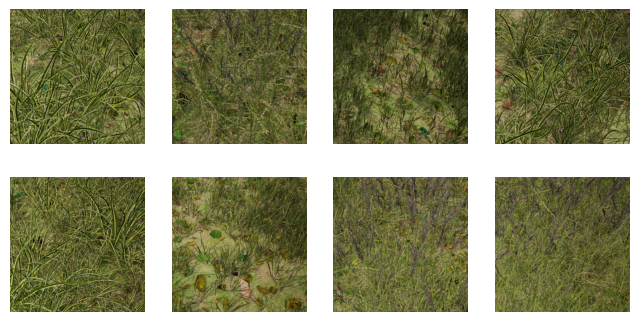

<Figure size 640x480 with 0 Axes>

In [12]:
images, masks = next(iter(train_loader))

show_images(2,4, images) 

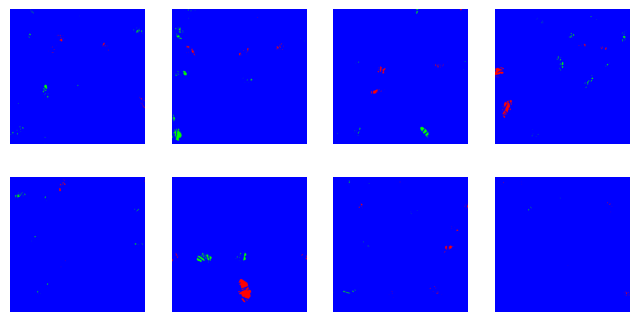

<Figure size 640x480 with 0 Axes>

In [13]:
show_images(2,4, masks)

In [14]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss

            if i % 500 == 0:

                print(f'{epoch} - {i}: {loss}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())


 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            best_val_loss = val_loss

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False


In [15]:
opt = torch.optim.Adam(model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stop = Early_Stopping(9)

In [16]:
train = False

if train:
    opt = torch.optim.Adam(model.parameters(), lr = 1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor = 0.1, patience=3)
    loss_fn = torch.nn.CrossEntropyLoss()
    early_stop = Early_Stopping(9)
    history = train(model, train_loader, val_loader, 100, loss_fn, opt, scheduler, early_stop, f'unet_grass')
else:
    reload = torch.load(f'unet_grass_best.pt')
    model.load_state_dict(reload['model'])
    model.to(device)

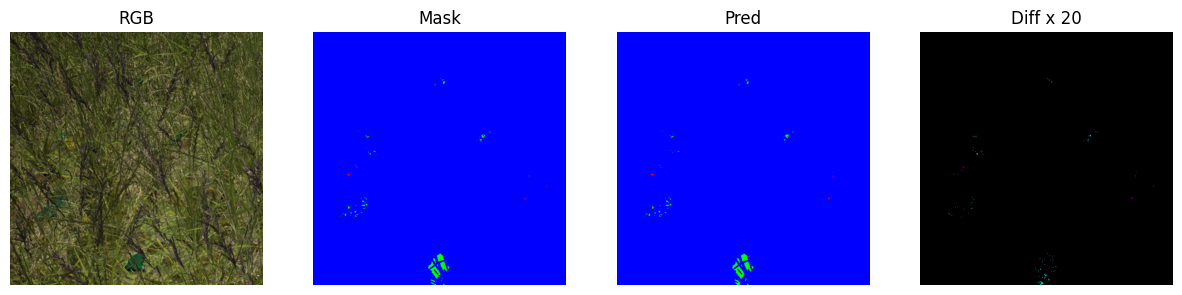

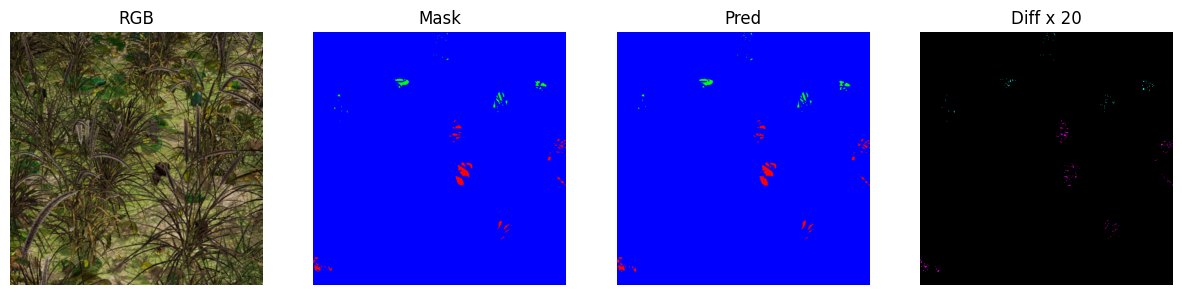

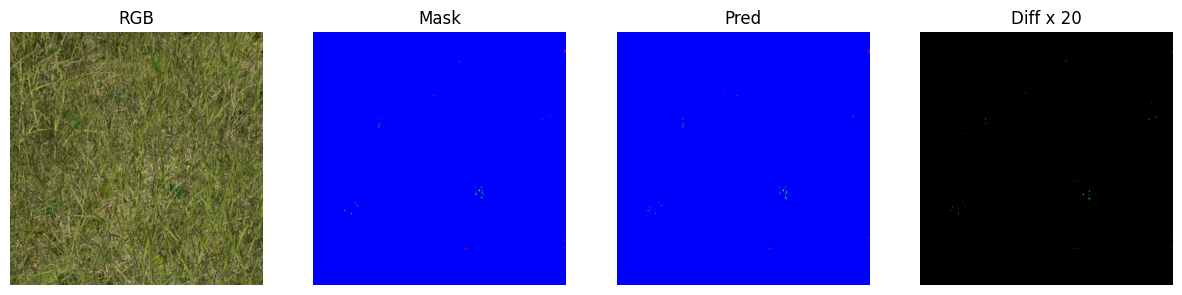

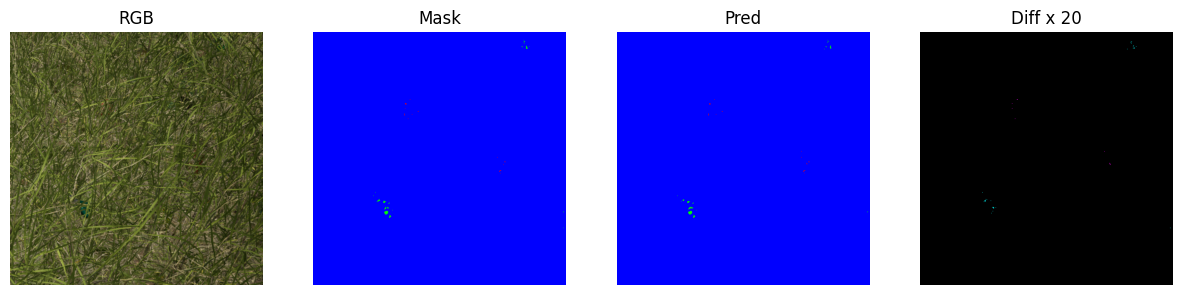

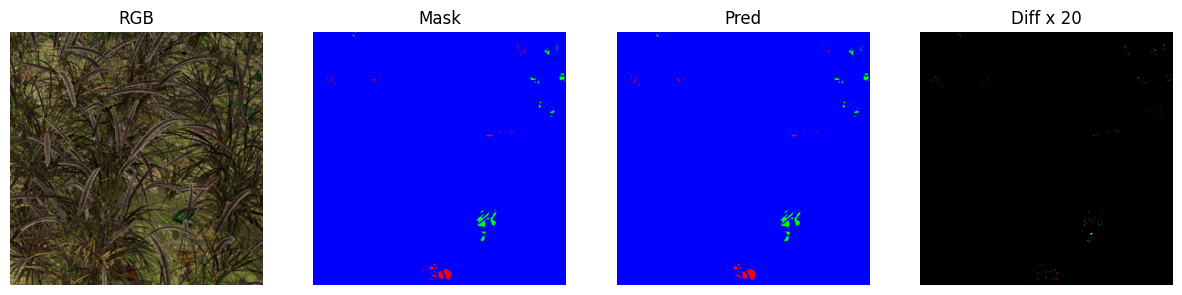

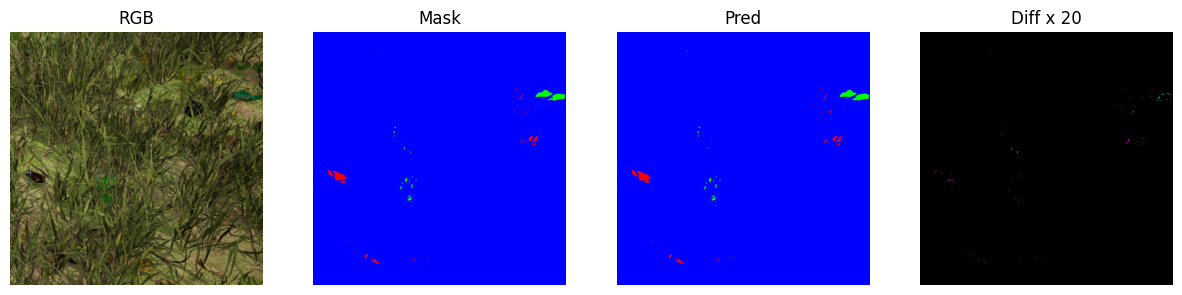

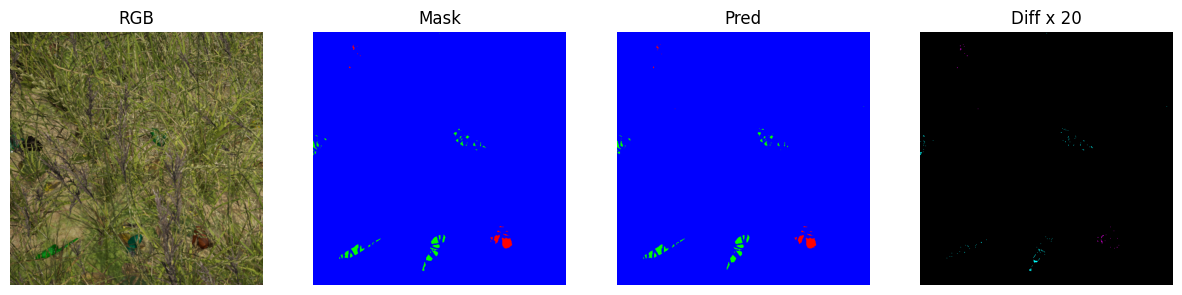

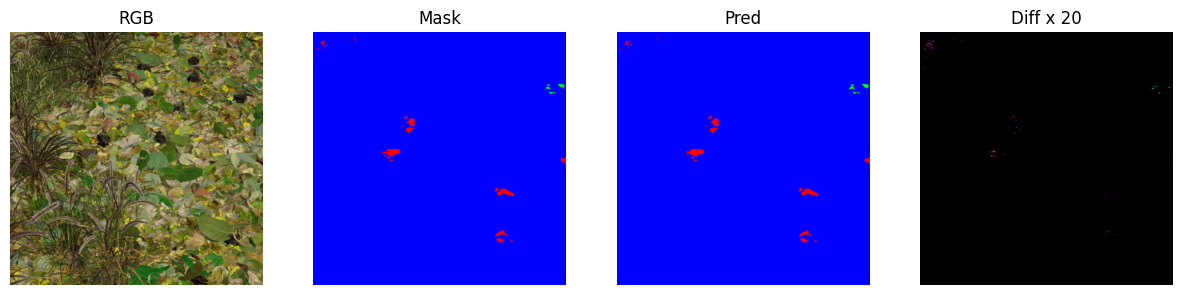

In [85]:
images, masks = next(iter(test_loader))

preds = model(images.to(device)).clamp(0,1)

for i in range(len(preds)):
    plot_predictions(images[i], masks[i], preds[i])

In [86]:
for i in range(BATCH_SIZE):
    m = np.transpose(masks[i].cpu().detach().numpy(), (1,2,0))

    p = np.transpose(preds[i].cpu().detach().numpy(), (1,2,0))

    clss = np.argmax(p, axis = 2)
    for i in range(512):
        for j in range(512):
            p[i,j] = (0,0,0)
            p[i,j][clss[i,j]] = 1


    green_mine_mask = np.ndarray.flatten(np.asarray(m[:,:,1]))
    green_mine_pred = np.ndarray.flatten(np.asarray(p[:,:,1]))

    brown_mine_mask = np.ndarray.flatten(np.asarray(m[:,:,0]))
    brown_mine_pred = np.ndarray.flatten(np.asarray(p[:,:,0]))

    one_gt = green_mine_mask == 1
    one_pred = green_mine_pred == 1

    tp = sum(one_gt & one_pred)
    fp = sum(~one_gt&one_pred)
    fn = sum(one_gt&~one_pred)

    jacard = tp / (tp + fn + fp)

    print(tp, fp, fn, jacard)

    from sklearn.metrics import jaccard_score
    jac = jaccard_score(green_mine_mask, green_mine_pred)
    print(jac)

    jac = jaccard_score(brown_mine_mask, brown_mine_pred)
    print(jac)



877 74 55 0.8717693836978131
0.8717693836978131
0.6792452830188679
547 58 51 0.8338414634146342
0.8338414634146342
0.810368349249659
78 28 27 0.5864661654135338
0.5864661654135338
0.631578947368421
127 13 22 0.7839506172839507
0.7839506172839507
0.7058823529411765
805 58 31 0.9004474272930649
0.9004474272930649
0.8471615720524017
743 39 19 0.9275905118601748
0.9275905118601748
0.8779284833538841
1273 84 92 0.8785369220151829
0.8785369220151829
0.9158415841584159
147 17 8 0.8546511627906976
0.8546511627906976
0.9157413455258001
